In [1]:
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import numpy as np

import geopandas as gpd
import seaborn as sns
import pandas as pd
from shapely.geometry import Polygon
import libpysal as ps
from scipy.stats import norm

In [2]:
img_path = r".\ref-imgs\pt2.jpg"
N = 8

out_dir_path = r".\results"

out_txt_path = os.path.join(out_dir_path, os.path.splitext(os.path.basename(img_path))[0]+".txt")

# palette = (
#     (3, 218, 3),       # dark green  -> 1
#     (111, 254, 103),   # light green -> 2
#     (254, 254, 254),   # white       -> 3
#     (254, 105, 112),   # light red   -> 4
#     (229, 0, 0),       # dark red    -> 5 
# )
palette = (
    (0,0,0),        # black -> 0
    (255,255,255)   # white -> 1
)

In [3]:
file_basename = os.path.splitext(os.path.basename(img_path))

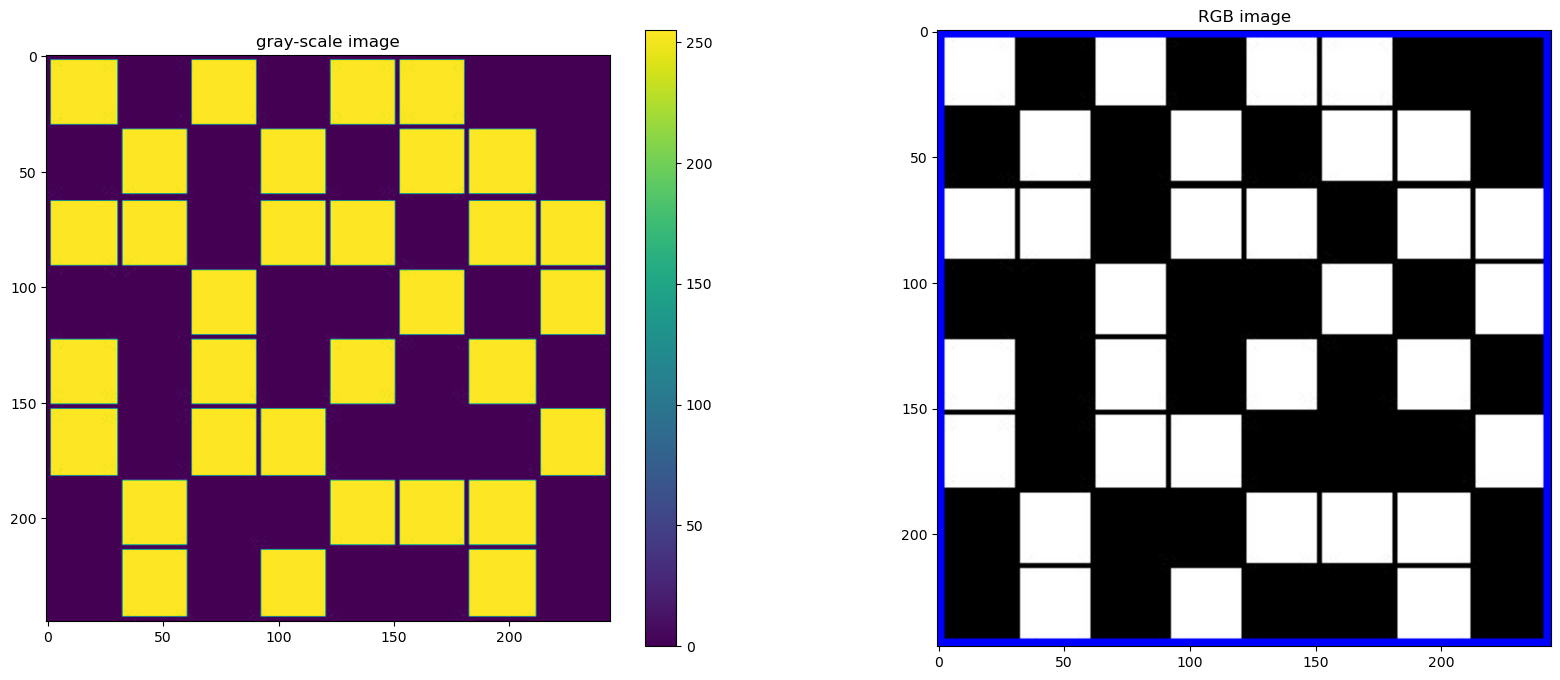

In [4]:
%matplotlib inline

image = Image.open(img_path)

#  translating the color image to grayscale (mode “L”)
gray_image = image.convert('L')

def find_bound_box(gary_img):
    # find bounding box
    width, height = gary_img.size
    left, top, right, bottom = width, height, 0, 0

    for y in range(height):
        for x in range(width):
            if gary_img.getpixel((x, y)) < 200:  # find black pixels
                if x < left:
                    left = x
                if x > right:
                    right = x
                if y < top:
                    top = y
                if y > bottom:
                    bottom = y
    
    return (left, top, right, bottom)

# draw bounding box

bound_box = find_bound_box(gray_image)

draw = ImageDraw.Draw(image)
draw.rectangle(list(bound_box), outline="blue",width=3)


# show results
fig = plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(1, 2) 

# plot 1
ax0 = fig.add_subplot(1,2,1);
img0 = ax0.imshow(gray_image)
ax0.set_title('gray-scale image')
plt.colorbar(img0)


# plot 2
ax1 = fig.add_subplot(1,2,2);
ax1.imshow(image)
ax1.set_title('RGB image') # 图像题目

plt.show()


In [5]:


left, top, right, bottom = bound_box

pixel_size =float(right-left+1)/N

mapped_values = []

def dist2(point1, point2):
    point1 = np.array(point1)
    point2 = np.array(point2)
    return np.sum((point1 - point2) ** 2)

# turn RGB value into mapped values
# by finding min distance
for i in range(N):
    for j in range(N):
        x = left + pixel_size*0.5 + pixel_size * j
        y = top  + pixel_size*0.5 + pixel_size * i
        pixel_value = image.getpixel((x, y))
        color_dists = list(map(lambda palette_value:  dist2(palette_value, pixel_value), palette))
        # argmin for mapped color
        mapped_values.append(color_dists.index(min(color_dists)) + 1) 
        



In [6]:
l = np.arange(N)
xs, ys = np.meshgrid(l, l)
ys = N-1-ys

polys = []

coord_ls = list(zip(xs.flatten(), ys.flatten()))

for item in coord_ls:
    x, y = item
    poly = Polygon([(x,y), (x+1,y), (x+1,y+1), (x,y+1)])
    polys.append(poly)

polys = gpd.GeoSeries(polys)
gdf = gpd.GeoDataFrame(
    {
        "geometry":polys,
        "id":[i for i in range(len(polys))],
        "value":mapped_values
    }
)


In [ ]:
wr = ps.weights.contiguity.Rook.from_dataframe(gdf)

# define color maps
rgb_values = [(r/255.0, g/255.0, b/255.0) for r, g, b in palette]
cmap = ListedColormap(rgb_values)

# Set up figure
f, ax = plt.subplots(1, 1, subplot_kw=dict(aspect="equal"),figsize=(10, 10))
# Plot vector grid
gdf.plot(column="value", ax=ax, cmap=cmap, legend=True,edgecolor='black')
ax.set_title('Vector grid from RGB image')
plt.show()

In [9]:
# calculate Moran's i
w = wr.full()[0].astype(float)

# row standardization
w = w.astype(float) / w.sum(axis=1,keepdims=True)

# column vector of ovservation values X
X = gdf["value"].to_numpy().reshape((N*N, 1))

# mean-centered X
X = X - X.mean()

S0 = w.sum()

moran_I = (N*N) / S0 * (X.T @ w @ X) / (X.T @ X)
assert moran_I.shape == (1, 1), "moran calculation error"
moran_I = moran_I[0, 0]
moran_I

-0.38802083333333326

In [10]:
# significance test
n = N*N
S1 = 0.0
S2 = 0.0

for i in range(w.shape[0]):
    for j in range(w.shape[1]):
        S1 += (w[i, j] + w[j, i])**2
S1 /= 2

w_s_row = w.sum(axis=1)
w_s_col = w.sum(axis=0)

for i in range(w.shape[0]):
    S2 += (w_s_row[i]+w_s_col[i])**2

E_I = -1.0 / (n-1)

b2 = n * (X**4).sum() / ((X**2).sum())**2
A = n*((n**2-3*n+3)*S1 - n*S2 + 3*S0**2)
B = b2*((n**2-n)*S1 - 2*n*S2 + 6*S0**2)
C = (n-1)*(n-2)*(n-3)*S0**2

Var_I =  (A-B) / C  - E_I**2
Z_I = (moran_I - E_I) / Var_I**0.5


p_value_two_tailed = 2 * (1 - norm.cdf(abs(Z_I)))


In [11]:
# calculate geary's C

# column vector of ovservation values X
X = gdf["value"].to_numpy().reshape((N*N, 1))

geary_C = 0.0
upper = 0.0
lower = 0.0
X_mean = X.mean()
for i in range(n):
    lower += (X[i]-X_mean)**2
    for j in range(n):
        upper += w[i, j] * (X[i]-X[j])**2
geary_C = (n-1) / (2*S0) * (upper / lower)
geary_C = geary_C[0]
geary_C

1.366333007812501

In [12]:
# significance test for geary's C
E_C = 1.0
DD = n*(n-2)*(n-3)*S0**2
AA = (n-1)*S1*(n**2-3*n+3-(n-1)*b2)
BB = 1/4*(n-1)*S2*(n**2+3*n-6-(n**2-n+2)*b2)
CC = S0**2*(n**2-3-(n-1)**2*b2)
Var_C = 1/DD*(AA-BB+CC)
Z_C = (geary_C - E_C) / Var_C**0.5


p_value_two_tailed_C = 2 * (1 - norm.cdf(abs(Z_C)))
p_value_two_tailed_C,Var_C,Z_C

(8.483336086895221e-05, 0.008687535270315695, 3.9303186431038744)

In [13]:
# save results to txt file
def save_dict_to_txt(dictionary, file_path):
    with open(file_path, 'w', encoding='utf-8') as file:
        for key, value in dictionary.items():
            file.write(f"{key}: {value}\n")

out_dict = {
    "image_filename": img_path,
    "moran_I"       : moran_I,
    "E_I"           : E_I,
    "Var_I"         : Var_I,
    "Z_I"           : Z_I,
    "P-value"       : p_value_two_tailed,
    "Geary's C"     : geary_C,
    "E_C"           : E_C,
    "Var_C"         : Var_C,
    "Z_C"           : Z_C,
    "P-value-c"     : p_value_two_tailed_C
}

save_dict_to_txt(out_dict, out_txt_path)
out_dict

{'image_filename': '.\\ref-imgs\\pt2.jpg',
 'moran_I': -0.38802083333333326,
 'E_I': -0.015873015873015872,
 'Var_I': 0.008965518888186716,
 'Z_I': -3.930318643103862,
 'P-value': 8.483336086895221e-05,
 "Geary's C": 1.366333007812501,
 'E_C': 1.0,
 'Var_C': 0.008687535270315695,
 'Z_C': 3.9303186431038744,
 'P-value-c': 8.483336086895221e-05}

In [14]:
2*(1 - norm.cdf(abs(-1.170841)))

0.24166269415640573

In [15]:
# ground truth for Moran's I
from esda.moran import Moran
import numpy as np
y = gdf["value"].to_numpy().reshape((N*N, 1))
mi = Moran(y,  wr)
mi.I,mi.z_rand,mi.p_rand

(-0.38802083333333337, -3.9303186431038615, 8.4833360868859e-05)

In [16]:
# ground truth for Geary's C
from esda.geary import Geary
y = gdf["value"].to_numpy().reshape((N*N, 1))
gc = Geary(y, wr)
# gc.p_rand is one tailed
gc.C, gc.z_rand,gc.p_rand

(1.3663330078125, 3.930318643103861, 4.241668043442958e-05)